In [47]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [48]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [49]:
# helper function for plotting out ground truth curves

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens5 == 1]
    counts = relapsed['Illicit_Days5'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [50]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

def run_models(X, y, label):
    rsf = RandomSurvivalForest()
    scores = cross_validate(rsf, X, y, cv=5)
    rsf_score = scores['test_score'].mean()
    print('RF score:', rsf_score)
    
    rsf = RandomSurvivalForest()
    rsf.fit(X, y)
    
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    # one-hot encode all variables (except primsev) to get hazards across groups, drop highest reference group
    lasso_X = get_lasso_features(X)
    
    scores = cross_validate(rcr, lasso_X, y, cv=5)
    rcr_score = scores['test_score'].mean()
    print('Lasso score:', rcr_score)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    rcr.fit(lasso_X, y)
    
    # concordance index
    scores = {'Model': ['Random Forest','Lasso','Dataset Size'], 
              label: [rsf_score,rcr_score,int(X.shape[0])]}
    
    concordance = pd.DataFrame(data=scores)
    
    # return scores and models
    return concordance, rsf, rcr

In [51]:
def get_survival_graph(rsf, rcr, X, Y, label, filename):
    pred_surv_rsf = rsf.predict_survival_function(X)
    
    # one-hot encode all variables (except primsev) to get hazards across groups, drop highest reference group
    lasso_X = get_lasso_features(X)
    
    pred_surv_rcr = rcr.predict_survival_function(lasso_X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(Y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [52]:
from tqdm.notebook import tqdm # used to show progress bar

def get_feature_importance(X, y, rsf, rcr, label):
    # feature importances from Random Forest
    feature_importance_rf = pd.DataFrame({'Feature':list(X.columns),})
    feature_importance_rf[label] = 0
    
    scores = cross_validate(rsf, X, y, cv=5)
    reference = scores['test_score'].mean()
    
    for i,row in tqdm(feature_importance_rf.iterrows(), total=feature_importance_rf.shape[0]):
        feat = row['Feature']
        temp_data = X.copy()
        temp_data[feat] = np.random.permutation(temp_data[feat].values)        
        temp_scores = cross_validate(rsf, temp_data, y, cv=5)
        temp_score = temp_scores['test_score'].mean()
        percent_change = (reference - temp_score) / reference * 100 # percent change
        if percent_change < 0:
            percent_change = 0 # removing feature helped model, should not be reflected in feature importance
        feature_importance_rf.iloc[i, feature_importance_rf.columns.get_loc(label)] = percent_change
            
    feature_importance_rf = feature_importance_rf.nlargest(10,[label]) # keep top 10 features

    # feature importances from Lasso
    lasso_X = get_lasso_features(X)
    feature_importance_lasso = pd.DataFrame({'Feature':list(lasso_X.columns), 
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    # remove features that were zero-ed out by lasso
    feature_importance_lasso = feature_importance_lasso[feature_importance_lasso[label] != 0] 
    # convert regression coefficients to hazard ratios
    feature_importance_lasso[label] = np.exp(feature_importance_lasso[label])
    # rank by magnitude of deviation from 1
    feature_importance_lasso[label + '_adjusted'] = np.absolute(feature_importance_lasso[label]-1)
    feature_importance_lasso = feature_importance_lasso.nlargest(10,[label + '_adjusted']) # keep top 10 features
    
    return feature_importance_rf, feature_importance_lasso

In [53]:
def get_lasso_features(X):
    features_to_ignore = ['female_cd','nonwhite_cd','unemplmt_cd','SUDSy','primsev_cd_1','primsev_cd_2',
                          'primsev_cd_3','primsev_cd_4','primsev_cd_5','primsev_cd_6']
    lasso_X = X.copy()
    for col in lasso_X.columns:
        if col not in features_to_ignore:
            one_hot = pd.get_dummies(lasso_X[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            lasso_X = lasso_X.drop(col,axis = 1)
            lasso_X = lasso_X.join(one_hot)
    #print(lasso_X.columns)
    return lasso_X

Survival Analysis by Severity

In [54]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('data/data_superset.csv')    
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,Address,lat,lng,state_name,county_FIPS,block_FIPS,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,closest,gran,point,pop_deng
0,0,1,2,929,OH,Cleveland,1276 West Third St. #400,2006,354,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,2,1,0,0,0,0,0,0,3,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,Ohio,39035.0,3.903511e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('41.501028000000005', '-81.697772')",0.0
1,1,2,3,951,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,Ohio,39035.0,3.903511e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('41.501028000000005', '-81.697772')",0.0
2,2,3,4,1032,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,2,0,1,1,1,1,1,0,2,1,0,2,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,Ohio,39035.0,3.903511e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('41.501028000000005', '-81.697772')",0.0
3,3,18,19,1673,KY,Louisville,1220 Bardstown Rd,2006,365,0,0,0,0,0,0,0,0,0,1,1,0,0,2,2,0,0,0,0,1,0,0,0,0,2,"1220 Bardstown Rd, Louisville, KY",38.236398,-85.717815,Kentucky,21111.0,2.111101e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('38.236397499999995', '-85.7178152')",0.0
4,4,21,22,3870,AZ,Tucson,3130 E Broadway Blvd,2006,5,1,0,0,0,1,2,1,2,2,2,1,2,1,1,2,2,2,0,0,1,0,0,0,0,11,"3130 E Broadway Blvd, Tucson, AZ",32.221465,-110.926070,Arizona,4019.0,4.019002e+13,0,0.0,0.0,0.0,0.0,NaN,1.0,"('32.2214651', '-110.92607029999999')",0.0


In [55]:
df['r4ag_0_cd'].value_counts()

2    4225
0    4108
1    1735
Name: r4ag_0_cd, dtype: int64

In [56]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','gran','srprobg_cd','county_FIPS','block_FIPS',
                'point','closest']

df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True) # drops any remaining rows with null values

# uncomment to get CONTROL statistics
#cols_to_drop = ['pop_deng','%_dropoutg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']
#df.drop(columns=cols_to_drop, inplace=True)

df = df.astype(int)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
df.shape

(10068, 31)

In [57]:
df.head()

,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,pop_deng
0,149,1,1,1,1,1,0,1,0,0,0,0,2,2,2,1,2,1,0,0,0,0,0,2,10,2,0,0,0,0,0
1,365,0,1,1,0,0,0,0,1,1,0,2,2,2,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,135,0,1,0,0,1,2,1,2,1,0,0,0,1,2,0,0,1,0,0,0,0,0,2,6,0,0,0,0,0,0
3,180,0,0,1,1,0,2,0,0,1,0,1,1,1,2,0,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0
4,112,0,0,1,0,0,0,0,1,1,1,2,2,1,1,2,2,0,0,1,0,0,0,1,4,0,0,0,0,0,0


Full Population Survival Analysis

In [58]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

predictor_var = 'Illicit_Days5'
censoring_var = 'Illicit_Cens5'

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(10068, 29) (10068,)


In [59]:
%%time
full_concordance, rsf, rcr = run_models(X, y, 'ALL')

RF score: 0.6729187092855099
Lasso score: 0.6818858447762428
CPU times: user 31.3 s, sys: 3.28 s, total: 34.6 s
Wall time: 37.7 s


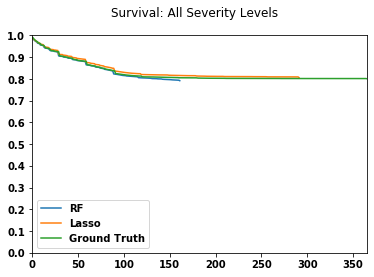

In [60]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: All Severity Levels','graphs/survival_all.png')

Subclinical Severity Survival Analysis

In [61]:
X = df[df.SUDSy_0 < 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3250, 28) (3250,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [62]:
%%time
subclinical_concordance, rsf, rcr = run_models(X, y, 'SUB')

RF score: 0.6539875838187909
Lasso score: 0.6881885648855273
CPU times: user 8.09 s, sys: 664 ms, total: 8.76 s
Wall time: 8.92 s


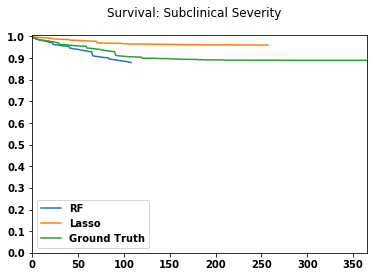

In [63]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Subclinical Severity', 'graphs/survival_subclinical.png')

In [64]:
%%time
subclinical_feature_importance_rf, subclinical_feature_importance_lasso = \
                                        get_feature_importance(X, y, rsf, rcr, 'SUB')


CPU times: user 2min 29s, sys: 6.84 s, total: 2min 36s
Wall time: 2min 49s


Mild/Moderate Severity Survival Analysis

In [65]:
X = df[df.SUDSy_0 >= 2]
X = X[X.SUDSy_0 <= 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2838, 28) (2838,)


In [66]:
%%time
mild_concordance, rsf, rcr = run_models(X, y, 'MILD')

RF score: 0.5715619738619677
Lasso score: 0.5985526576573125
CPU times: user 6.99 s, sys: 442 ms, total: 7.43 s
Wall time: 6.97 s


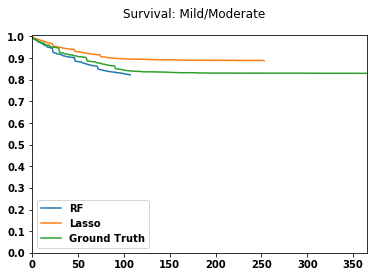

In [67]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Mild/Moderate', 'graphs/survival_mild.png')

In [68]:
%%time
mild_feature_importance_rf, mild_feature_importance_lasso = get_feature_importance(X, y, rsf, rcr, 'MILD')


CPU times: user 2min 19s, sys: 7.1 s, total: 2min 26s
Wall time: 2min 36s


Severe Severity Survival Analysis

In [69]:
X = df[df.SUDSy_0 > 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3980, 28) (3980,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [70]:
%%time
severe_concordance, rsf, rcr = run_models(X, y, 'SEVERE')

RF score: 0.6101425909578948
Lasso score: 0.6177165003984422
CPU times: user 10.5 s, sys: 963 ms, total: 11.4 s
Wall time: 11.3 s


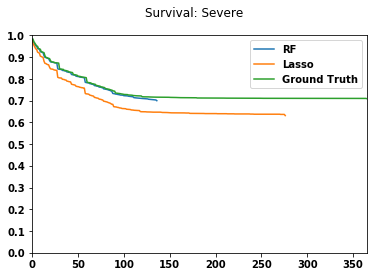

In [71]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Severe', 'graphs/survival_severe.png')

In [72]:
%%time
severe_feature_importance_rf, severe_feature_importance_lasso = get_feature_importance(X, y, rsf, rcr, 'SEVERE')


CPU times: user 3min 29s, sys: 19.9 s, total: 3min 49s
Wall time: 4min 5s


Overall Statistics

In [73]:
overall_concordance = pd.concat([subclinical_concordance, mild_concordance['MILD'], severe_concordance['SEVERE'],  
                                 full_concordance['ALL']], axis=1)
pd.DataFrame(data=overall_concordance).round(4)

,Model,SUB,MILD,SEVERE,ALL
0,Random Forest,0.6540,0.5716,0.6101,0.6729
1,Lasso,0.6882,0.5986,0.6177,0.6819
2,Dataset Size,3250.0000,2838.0000,3980.0000,10068.0000


In [74]:
overall_feature_importance_lasso = pd.merge(subclinical_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
0,cjsig_0_cd_2,1.227673,0.227673,0.000000,0.000000,0.000000,0.000000
1,B2a_0g_2,1.190314,0.190314,0.000000,0.000000,0.963094,0.036906
2,murder_numg_0,1.159066,0.159066,1.061701,0.061701,0.000000,0.000000
3,gvsg_cd_0,0.871967,0.128033,0.000000,0.000000,0.000000,0.000000
4,murder_numg_2,1.107949,0.107949,1.070784,0.070784,0.000000,0.000000
5,r4ag_0_cd_0,0.894376,0.105624,0.914863,0.085137,0.817375,0.182625
6,%_povertyg_0,0.903402,0.096598,0.819558,0.180442,0.000000,0.000000
7,dssg_0_cd_0,0.925699,0.074301,0.000000,0.000000,0.942249,0.057751
8,cjsig_0_cd_0,0.925837,0.074163,0.000000,0.000000,0.000000,0.000000
9,primsev_cd_2,0.949697,0.050303,0.000000,0.000000,0.000000,0.000000


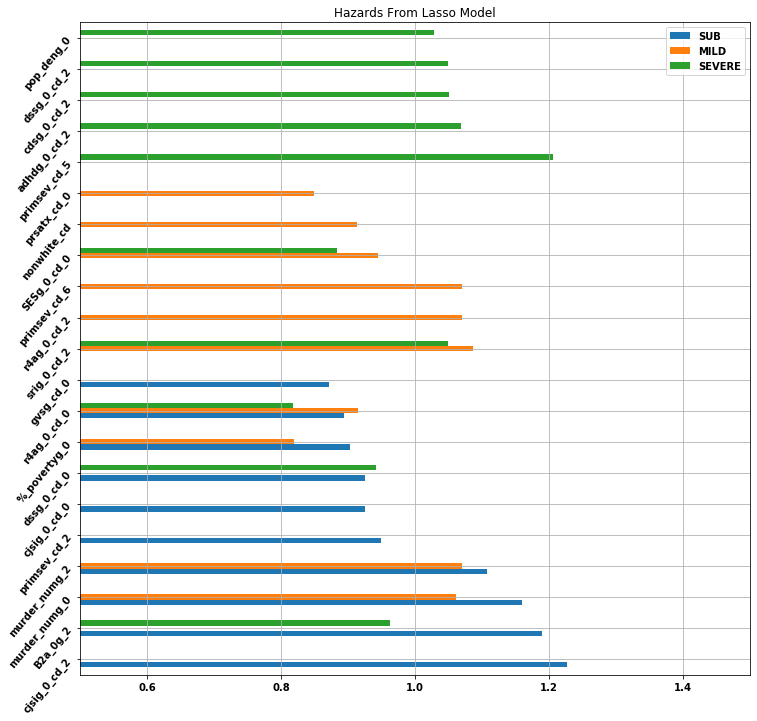

In [75]:
haz_df = pd.DataFrame({'SUB': overall_feature_importance_lasso['SUB'].tolist(),
                   'MILD': overall_feature_importance_lasso['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_lasso['SEVERE'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
haz_df = haz_df.replace(1, 0)
haz_df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = haz_df.plot.barh(rot=50, figsize=(12, 12))
ax.set_xlim([0.5,1.5])
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('graphs/hazards_lasso.png', bbox_inches='tight')

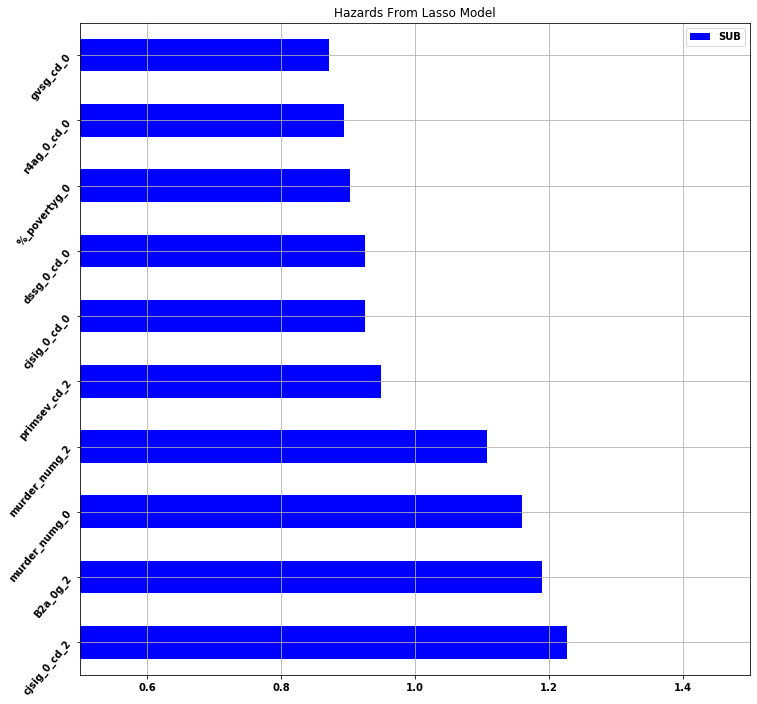

In [76]:
haz_sub = pd.DataFrame({'SUB': overall_feature_importance_lasso['SUB'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
haz_sub = haz_sub[haz_sub.SUB != 0]
haz_sub.sort_values(by=['SUB'], ascending=False, inplace=True)

ax = haz_sub.plot.barh(rot=50, figsize=(12, 12), color='blue')
ax.set_xlim([0.5,1.5])
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('graphs/hazards_lasso_sub.png', bbox_inches='tight')

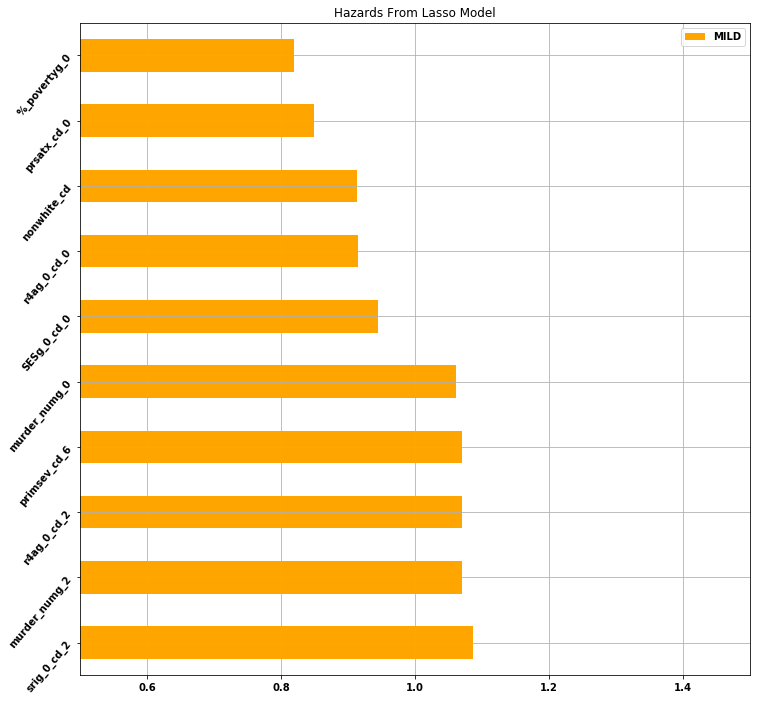

In [77]:
haz_mild = pd.DataFrame({'MILD': overall_feature_importance_lasso['MILD'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
haz_mild = haz_mild[haz_mild.MILD != 0]
haz_mild.sort_values(by=['MILD'], ascending=False, inplace=True)

ax = haz_mild.plot.barh(rot=50, figsize=(12, 12), color='orange')
ax.set_xlim([0.5,1.5])
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('graphs/hazards_lasso_mild.png', bbox_inches='tight')

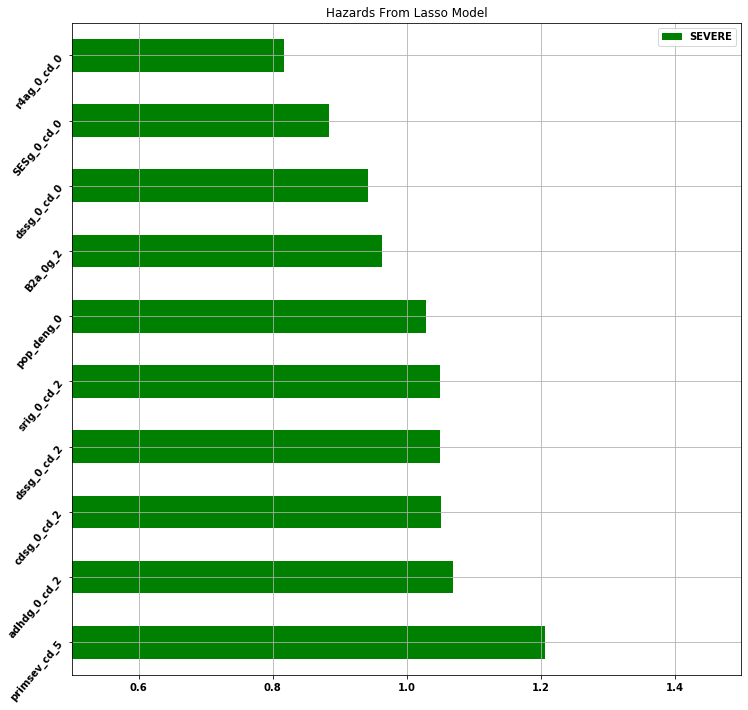

In [78]:
haz_severe = pd.DataFrame({'SEVERE': overall_feature_importance_lasso['SEVERE'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
haz_severe = haz_severe[haz_severe.SEVERE != 0]
haz_severe.sort_values(by=['SEVERE'], ascending=False, inplace=True)

ax = haz_severe.plot.barh(rot=50, figsize=(12, 12), color='green')
ax.set_xlim([0.5,1.5])
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('graphs/hazards_lasso_severe.png', bbox_inches='tight')

In [79]:
overall_feature_importance_rf = pd.merge(subclinical_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,B2a_0g,2.439656,0.000000,0.000000
1,nonwhite_cd,1.274638,2.242264,0.000000
2,CWSg_0_cd,1.152854,0.000000,0.000000
3,cjsig_0_cd,0.899658,2.176948,0.000000
4,primsev_cd_1,0.744440,0.000000,0.517828
,Feature,SUB,MILD,SEVERE
5,%_public_assistanceg,0.657207,0.000000,0.000000
6,srig_0_cd,0.592309,1.560394,0.000000
7,pop_deng,0.573440,0.000000,0.589556
8,SESg_0_cd,0.480806,2.312789,0.875159


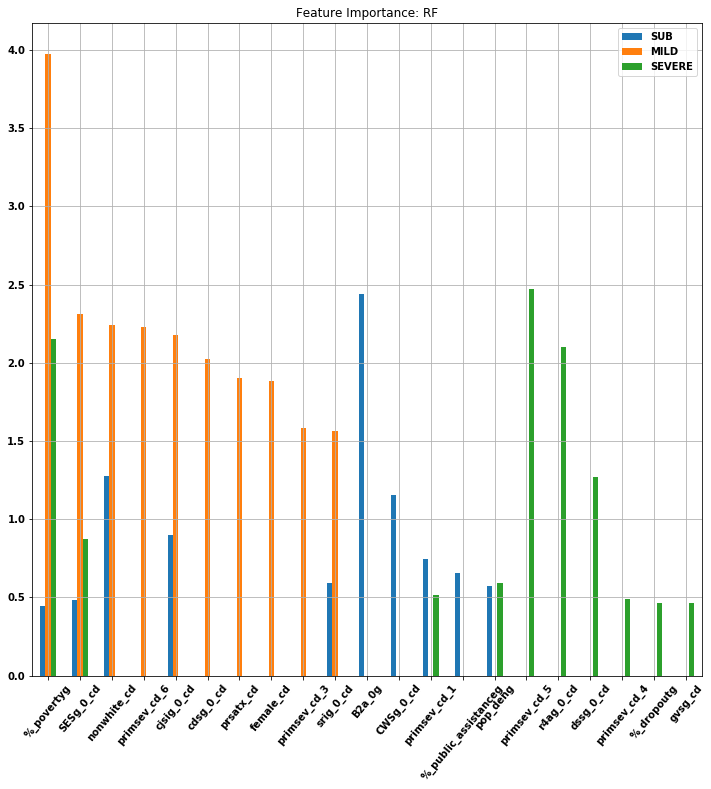

In [80]:
# feature importance for rf across all ages
feature_importance = pd.DataFrame({'SUB': overall_feature_importance_rf['SUB'].tolist(),
                   'MILD': overall_feature_importance_rf['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_rf['SEVERE'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
# John asked to sort this graph by MILD
feature_importance.sort_values(by=['MILD','SUB','SEVERE'], ascending=False, inplace=True)
ax = feature_importance.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance.png', bbox_inches='tight')

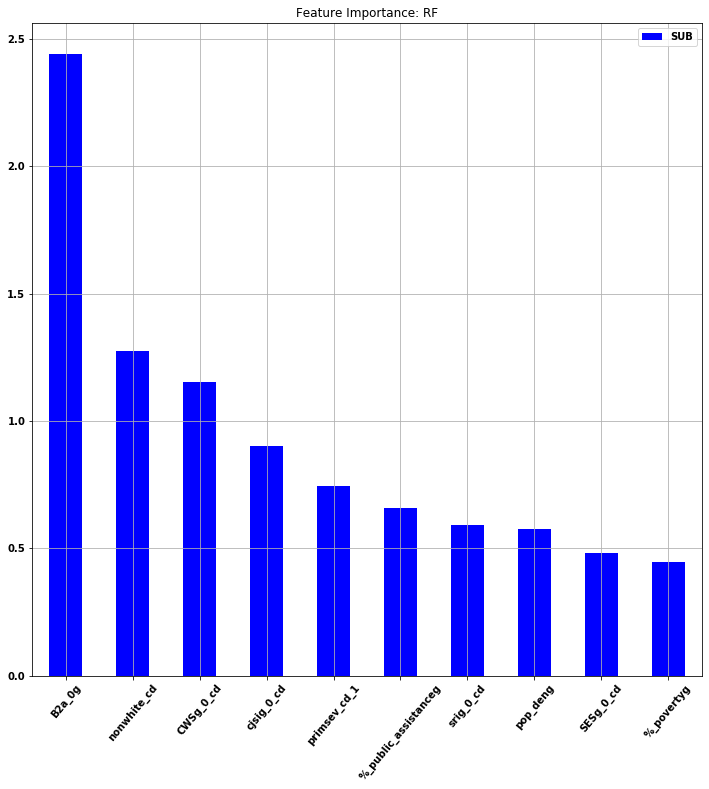

In [81]:
# feature importance for rf across all ages
feature_importance_sub = pd.DataFrame({'SUB': overall_feature_importance_rf['SUB'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
feature_importance_sub = feature_importance_sub[feature_importance_sub.SUB != 0]
# John asked to sort this graph by MILD
feature_importance_sub.sort_values(by=['SUB'], ascending=False, inplace=True)
ax = feature_importance_sub.plot.bar(rot=50, figsize=(12, 12), color='blue')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_sub.png', bbox_inches='tight')

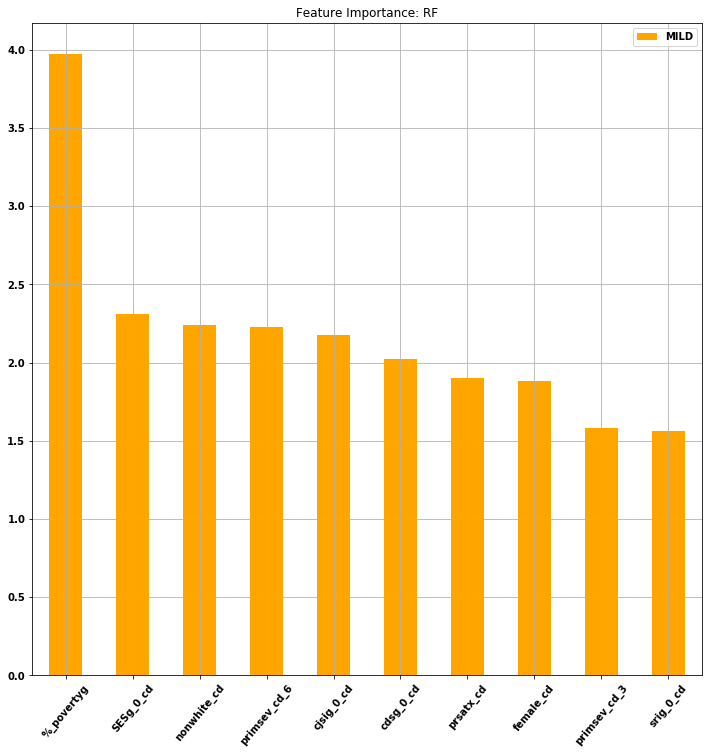

In [82]:
# feature importance for rf across all ages
feature_importance_mild = pd.DataFrame({'MILD': overall_feature_importance_rf['MILD'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
feature_importance_mild = feature_importance_mild[feature_importance_mild.MILD != 0]
# John asked to sort this graph by MILD
feature_importance_mild.sort_values(by=['MILD'], ascending=False, inplace=True)
ax = feature_importance_mild.plot.bar(rot=50, figsize=(12, 12), color='orange')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_mild.png', bbox_inches='tight')

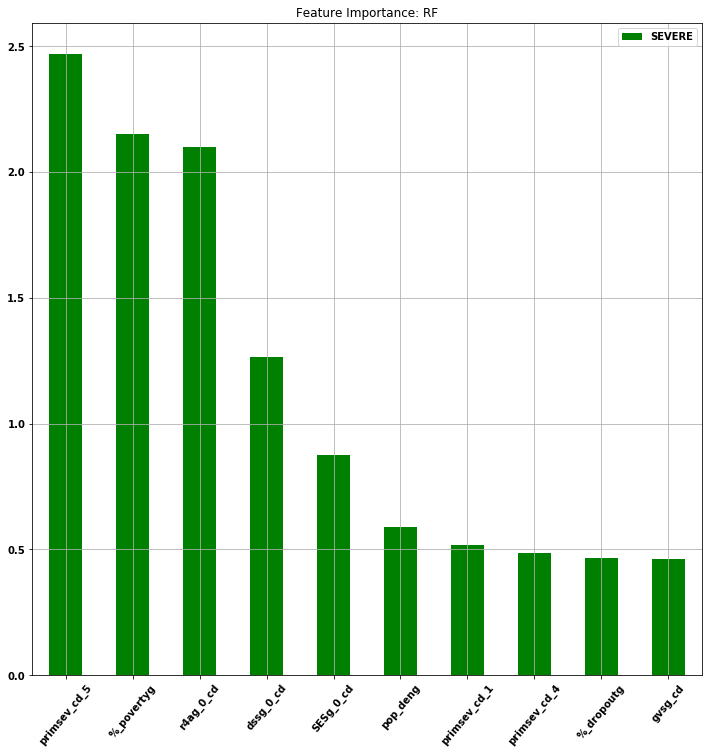

In [83]:
# feature importance for rf across all ages
feature_importance_severe = pd.DataFrame({'SEVERE': overall_feature_importance_rf['SEVERE'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
feature_importance_severe = feature_importance_severe[feature_importance_severe.SEVERE != 0]
# John asked to sort this graph by MILD
feature_importance_severe.sort_values(by=['SEVERE'], ascending=False, inplace=True)
ax = feature_importance_severe.plot.bar(rot=50, figsize=(12, 12), color='green')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_severe.png', bbox_inches='tight')

In [84]:
# top features in both models across all severity groups
rf = overall_feature_importance_rf['Feature'].tolist()
lasso = overall_feature_importance_lasso['Feature'].tolist()

common_features = []
lasso_common_features = []

for elem_rf in rf:
    for elem_lasso in lasso:
        if elem_lasso.startswith(elem_rf):
            common_features.append(elem_rf)
            lasso_common_features.append(elem_lasso)

common_features = list(set(common_features))
lasso_common_features = list(set(lasso_common_features))

In [85]:
def analyze_common_features(subgroup):
    global common_features
    global lasso_common_features
    
    data = []

    for feat in common_features:
        temp = []
        temp.append(feat)
        temp.append(float(overall_feature_importance_rf.loc[overall_feature_importance_rf['Feature'] == feat, subgroup]))
        for i,row in overall_feature_importance_lasso.iterrows():
            if row['Feature'].startswith(feat):
                temp.append((row['Feature'], row[subgroup]))
        data.append(temp)

    df = pd.DataFrame(data=data, columns=['Feature', 'RF', 'Lasso', 'Lasso_'])
    df = df.fillna(0)
    
    """for i,row in df.iterrows():
        if row['Lasso'][1] == 0:
            df.iloc[i, df.columns.get_loc('Lasso')] = np.nan
    df = df.dropna()
    
    
    df = df[df.RF != 0]"""
    return df

In [86]:
analyze_common_features('SUB')

,Feature,RF,Lasso,Lasso_
0,pop_deng,0.573440,"(pop_deng_0, 0.0)",0
1,primsev_cd_6,0.000000,"(primsev_cd_6, 0.0)",0
2,prsatx_cd,0.000000,"(prsatx_cd_0, 0.0)",0
3,primsev_cd_5,0.000000,"(primsev_cd_5, 0.0)",0
4,r4ag_0_cd,0.000000,"(r4ag_0_cd_0, 0.8943756250236367)","(r4ag_0_cd_2, 0.0)"
5,srig_0_cd,0.592309,"(srig_0_cd_2, 0.0)",0
6,B2a_0g,2.439656,"(B2a_0g_2, 1.190314278250104)",0
7,cjsig_0_cd,0.899658,"(cjsig_0_cd_2, 1.2276726576437922)","(cjsig_0_cd_0, 0.9258371119040572)"
8,cdsg_0_cd,0.000000,"(cdsg_0_cd_2, 0.0)",0
9,gvsg_cd,0.000000,"(gvsg_cd_0, 0.8719665245021884)",0


In [87]:
analyze_common_features('MILD')

,Feature,RF,Lasso,Lasso_
0,pop_deng,0.000000,"(pop_deng_0, 0.0)",0
1,primsev_cd_6,2.226833,"(primsev_cd_6, 1.0700582678355541)",0
2,prsatx_cd,1.900921,"(prsatx_cd_0, 0.8493564319288581)",0
3,primsev_cd_5,0.000000,"(primsev_cd_5, 0.0)",0
4,r4ag_0_cd,0.000000,"(r4ag_0_cd_0, 0.914863462824036)","(r4ag_0_cd_2, 1.0706710621496862)"
5,srig_0_cd,1.560394,"(srig_0_cd_2, 1.0859730943172983)",0
6,B2a_0g,0.000000,"(B2a_0g_2, 0.0)",0
7,cjsig_0_cd,2.176948,"(cjsig_0_cd_2, 0.0)","(cjsig_0_cd_0, 0.0)"
8,cdsg_0_cd,2.025326,"(cdsg_0_cd_2, 0.0)",0
9,gvsg_cd,0.000000,"(gvsg_cd_0, 0.0)",0


In [88]:
analyze_common_features('SEVERE')

,Feature,RF,Lasso,Lasso_
0,pop_deng,0.589556,"(pop_deng_0, 1.0287385555084427)",0
1,primsev_cd_6,0.000000,"(primsev_cd_6, 0.0)",0
2,prsatx_cd,0.000000,"(prsatx_cd_0, 0.0)",0
3,primsev_cd_5,2.469815,"(primsev_cd_5, 1.206089393203066)",0
4,r4ag_0_cd,2.099218,"(r4ag_0_cd_0, 0.8173748295251714)","(r4ag_0_cd_2, 0.0)"
5,srig_0_cd,0.000000,"(srig_0_cd_2, 1.0494541105644781)",0
6,B2a_0g,0.000000,"(B2a_0g_2, 0.9630940196453059)",0
7,cjsig_0_cd,0.000000,"(cjsig_0_cd_2, 0.0)","(cjsig_0_cd_0, 0.0)"
8,cdsg_0_cd,0.000000,"(cdsg_0_cd_2, 1.0509071441402698)",0
9,gvsg_cd,0.462539,"(gvsg_cd_0, 0.0)",0


In [89]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 10 minutes 52 seconds ---
